In [8]:
from rdkit import Chem
import pandas as pd

In [5]:
input_mol_file = "/Users/macbook/CODE/DreaMS_MIMB/data/molecules/structures_v2.sdf"

In [6]:
supplier = Chem.SDMolSupplier(
    input_mol_file,
    removeHs=False
)
mols = [mol for mol in supplier if mol is not None]
print(f"Loaded {len(mols)} molecules")

Loaded 33 molecules


[09:07:13] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[09:07:13] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 10 ignored
[09:07:13] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored


In [7]:

# 1) load
supplier = Chem.SDMolSupplier(input_mol_file, removeHs=False)
mols     = [m for m in supplier if m is not None]

# 2) get InChIKeys
inchikeys = [Chem.MolToInchiKey(m) for m in mols]

# 3) also get non‐stereo SMILES (to collapse undefined stereo)
smis_noniso = [Chem.MolToSmiles(m, isomericSmiles=False) for m in mols]

print(f"Total records loaded:       {len(mols)}")
print(f"Unique InChIKeys:           {len(set(inchikeys))}")
print(f"Unique SMILES (ignore stereo): {len(set(smis_noniso))}")

Total records loaded:       33
Unique InChIKeys:           29
Unique SMILES (ignore stereo): 31


[09:07:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[09:07:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 10 ignored
[09:07:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored


In [ ]:
okey, for that i created CSV from their paper it is saved at /Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids.csv



In [9]:
# Replace 'your_file.csv' with the actual file name
df = pd.read_csv('/Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids.csv')


In [10]:
# Preview the first few rows
df.head()

,Name,Adduct,m/z,RT (min),MZmine ID,Annotation
0,Piperlongumine (1),[M+H]+,318.1342,8.83,452,Standard
1,Dihydropiperlongumine (2),[M+H]+,320.1497,9.07,463,Standard
2,"1-(3,4,5-Trimethoxycinnamoyl)piperidine (3)",[M+H]+,306.1705,8.90,458,Standard
3,"1-(3,4,5-Trimethoxycinnamoyl)-3-piperideine (4)",[M+H]+,304.1548,9.56,503,MS/MS
4,3'-Demethoxypiperlongumine (5),[M+H]+,288.1235,8.50,406,Standard


In [13]:
df.columns

Index(['Name', 'Adduct', 'm/z', 'RT (min)', 'MZmine ID', 'Annotation'], dtype='object')

### Try to match paper mols to provided mols

In [14]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# 1) load the paper’s CSV (adjust path as needed)
paper = pd.read_csv("/Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids.csv")
paper['m/z'] = pd.to_numeric(paper['m/z'], errors='coerce')
paper = paper.dropna(subset=['m/z']).sort_values('m/z').reset_index(drop=True)

# 2) load your 33 molecules
supplier = Chem.SDMolSupplier("/Users/macbook/CODE/DreaMS_MIMB/data/molecules/structures_v2.sdf", removeHs=False)
mols = [m for m in supplier if m is not None]

[09:57:18] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[09:57:18] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 10 ignored
[09:57:18] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored


In [15]:
# 3) build an RDKit DataFrame with computed [M+H]+ masses
records = []
for idx, mol in enumerate(mols, start=1):
    exact = Descriptors.ExactMolWt(mol)
    m_plus_h = exact + 1.007276466  # proton mass
    records.append({
        "Index": idx,
        "SMILES": Chem.MolToSmiles(mol, isomericSmiles=False),
        "ExactMass": exact,
        "M+H_m/z": m_plus_h
    })
rdkit_df = pd.DataFrame(records).sort_values("M+H_m/z").reset_index(drop=True)

In [16]:
# 4) align on nearest match within 0.01 Da
aligned = pd.merge_asof(
    paper,
    rdkit_df,
    left_on="m/z",
    right_on="M+H_m/z",
    direction="nearest",
    tolerance=0.01
)
aligned["Δm/z"] = aligned["M+H_m/z"] - aligned["m/z"]

In [17]:

# 5) summary
n_paper     = len(paper)
n_rdkit     = len(rdkit_df)
matched_idx = aligned['Index'].dropna().unique()
unmatched   = set(rdkit_df['Index']) - set(matched_idx)

print(f"Paper compounds:        {n_paper}")
print(f"RDKit molecules found:  {n_rdkit}")
print(f"Unique matches found:   {len(matched_idx)}")
print(f"Unmatched RDKit indices: {sorted(unmatched)}")

# show the full table so you can eyeball Name ↔ SMILES ↔ Δm/z
aligned

Paper compounds:        23
RDKit molecules found:  33
Unique matches found:   0
Unmatched RDKit indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


,Name,Adduct,m/z,RT (min),MZmine ID,Annotation,Index,SMILES,ExactMass,M+H_m/z,Δm/z
0,Piperolactam A (21),[M+H]+,266.0813,8.39,403,MS/MS,NaN,NaN,NaN,NaN,NaN
1,Asimilobine (18),[M+H]+,268.1335,5.32,279,MS/MS,NaN,NaN,NaN,NaN,NaN
2,Higenamine (9),[M+H]+,272.1284,3.31,130,Standard,NaN,NaN,NaN,NaN,NaN
3,"1-(3,4-Dimethoxycinnamoyl)piperidine (6)",[M+H]+,276.1598,8.58,411,Standard,NaN,NaN,NaN,NaN,NaN
4,Lirinidine (19),[M+H]+,282.1494,5.83,298,Standard,NaN,NaN,NaN,NaN,NaN
5,N-methylhigenamine (12),[M+H]+,286.1441,3.88,185,MS/MS,NaN,NaN,NaN,NaN,NaN
6,Piperine (8),[M+H]+,286.1442,10.12,555,Standard,NaN,NaN,NaN,NaN,NaN
7,Coclaurine (10),[M+H]+,286.1442,4.11,202,Standard,NaN,NaN,NaN,NaN,NaN
8,Isococlaurine (11),[M+H]+,286.1442,5.11,270,MS/MS,NaN,NaN,NaN,NaN,NaN
9,3'-Demethoxypiperlongumine (5),[M+H]+,288.1235,8.50,406,Standard,NaN,NaN,NaN,NaN,NaN


In [18]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# constants
CSV_PATH  = "/Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids.csv"
SDF_PATH  = "/Users/macbook/CODE/DreaMS_MIMB/data/molecules/structures_v2.sdf"
PROTON    = 1.007276466

# 1) load paper compounds
paper = pd.read_csv(CSV_PATH)
paper['m/z'] = pd.to_numeric(paper['m/z'], errors='coerce')
paper = paper.dropna(subset=['m/z']).reset_index(drop=True)

# helper to apply the right adduct mass shift
def mz_from_exact(exact_mass, adduct):
    if "[M+H]+" in adduct:
        return exact_mass + PROTON
    elif "[M]" == adduct.strip():
        return exact_mass
    else:
        # you can extend this for other adduct types if needed
        return exact_mass

# 2) load your 33 molecules
supplier = Chem.SDMolSupplier(SDF_PATH, removeHs=False)
mols     = [m for m in supplier if m is not None]

# 3) compute exact mass for each and store
compounds = []
for idx, mol in enumerate(mols, start=1):
    exact = Descriptors.ExactMolWt(mol)
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    compounds.append({
        'Index': idx,
        'ExactMass': exact,
        'SMILES': smiles
    })
comp_df = pd.DataFrame(compounds)

# 4) for each paper row, find the RDKit molecule with the smallest |computed_mz – reported_mz|
matches = []
for _, row in paper.iterrows():
    target_mz = row['m/z']
    best_idx, best_smi, best_cmz, best_diff = None, None, None, float('inf')
    for _, c in comp_df.iterrows():
        cmz  = mz_from_exact(c['ExactMass'], row['Adduct'])
        diff = abs(cmz - target_mz)
        if diff < best_diff:
            best_diff   = diff
            best_idx    = c['Index']
            best_smi    = c['SMILES']
            best_cmz    = cmz
    matches.append({
        'Name':       row['Name'],
        'Adduct':     row['Adduct'],
        'Reported m/z':  target_mz,
        'Match Index':   best_idx,
        'SMILES':        best_smi,
        'Computed m/z':  best_cmz,
        'Δ m/z':         best_diff
    })

match_df = pd.DataFrame(matches).sort_values('Name')

# show result
print(f"Paper entries : {len(paper)}")
print(f"RDKit records : {len(comp_df)}")
print("\nClosest‐match table (one row per paper compound):")
match_df

Paper entries : 23
RDKit records : 33

Closest‐match table (one row per paper compound):


[10:01:27] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[10:01:27] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 10 ignored
[10:01:27] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored


,Name,Adduct,Reported m/z,Match Index,SMILES,Computed m/z,Δ m/z
3,"1-(3,4,5-Trimethoxycinnamoyl)-3-piperideine (4)",[M+H]+,304.1548,20,[C]Oc1[c]c([C][C]c2[c][c]c([O])[c][c]2)c([C][C...,302.995094,1.159706
2,"1-(3,4,5-Trimethoxycinnamoyl)piperidine (3)",[M+H]+,306.1705,20,[C]Oc1[c]c([C][C]c2[c][c]c([O])[c][c]2)c([C][C...,302.995094,3.175406
5,"1-(3,4-Dimethoxycinnamoyl)piperidine (6)",[M+H]+,276.1598,16,[C][N+]1([C])[C][C]c2[c]c([O])c([O])[c]c2[C]1[...,278.994546,2.834746
4,3'-Demethoxypiperlongumine (5),[M+H]+,288.1235,23,[C]Oc1[c]c2c([c]c1[O])[C][C][N+]([C])([C])[C]2...,290.994546,2.871046
17,Asimilobine (18),[M+H]+,268.1335,1,O=C([C]=[C][C]=[C]c1[c][c]c2c([c]1)O[C]O2)N1[C...,266.995094,1.138406
9,Coclaurine (10),[M+H]+,286.1442,3,[C]Oc1[c]c([C]=[C]C(=O)N2[C][C][C][C][C]2)[c]c...,282.990009,3.154191
21,Cuspidatin (22),[M+H]+,330.2067,9,[C]Oc1[c][c]c2c(c1[O])-c1c([O])c(O[C])[c]c3c1[...,318.989460,11.217240
1,Dihydropiperlongumine (2),[M+H]+,320.1497,9,[C]Oc1[c][c]c2c(c1[O])-c1c([O])c(O[C])[c]c3c1[...,318.989460,1.160240
22,Fimbriulatumine (23),[M]+,344.2226,9,[C]Oc1[c][c]c2c(c1[O])-c1c([O])c(O[C])[c]c3c1[...,317.982184,26.240416
8,Higenamine (9),[M+H]+,272.1284,5,[C]Oc1[c][c]c([C]=[C]C(=O)N2[C][C][C]=[C]C2=O)...,270.990009,1.138391


In [19]:
print(match_df)

                                               Name  Adduct  Reported m/z  \
3   1-(3,4,5-Trimethoxycinnamoyl)-3-piperideine (4)  [M+H]+      304.1548   
2       1-(3,4,5-Trimethoxycinnamoyl)piperidine (3)  [M+H]+      306.1705   
5          1-(3,4-Dimethoxycinnamoyl)piperidine (6)  [M+H]+      276.1598   
4                    3'-Demethoxypiperlongumine (5)  [M+H]+      288.1235   
17                                 Asimilobine (18)  [M+H]+      268.1335   
9                                   Coclaurine (10)  [M+H]+      286.1442   
21                                  Cuspidatin (22)  [M+H]+      330.2067   
1                         Dihydropiperlongumine (2)  [M+H]+      320.1497   
22                             Fimbriulatumine (23)    [M]+      344.2226   
8                                    Higenamine (9)  [M+H]+      272.1284   
10                               Isococlaurine (11)  [M+H]+      286.1442   
18                                  Lirinidine (19)  [M+H]+      282.1494   

--- Molecule index: 0 ---


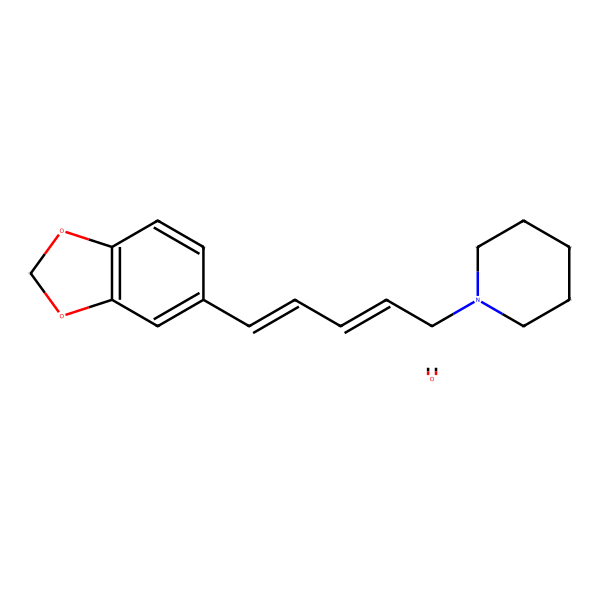

--- Molecule index: 1 ---


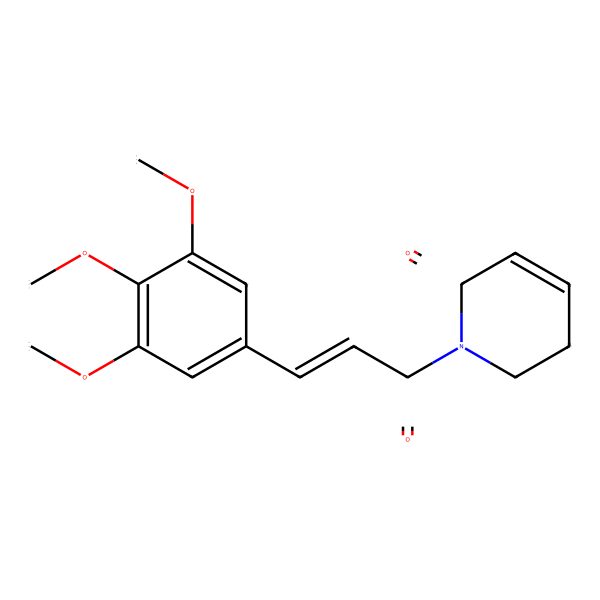

--- Molecule index: 2 ---


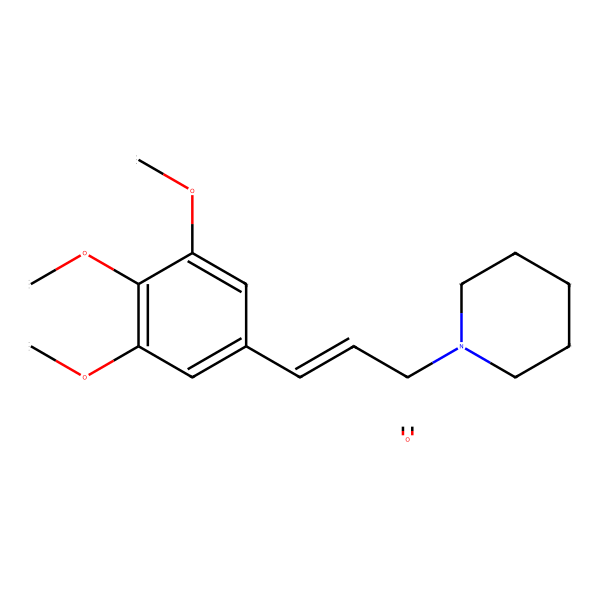

--- Molecule index: 3 ---


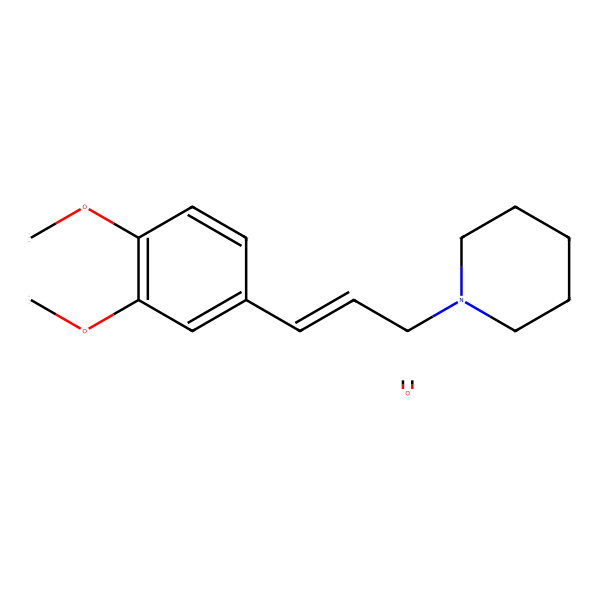

--- Molecule index: 4 ---


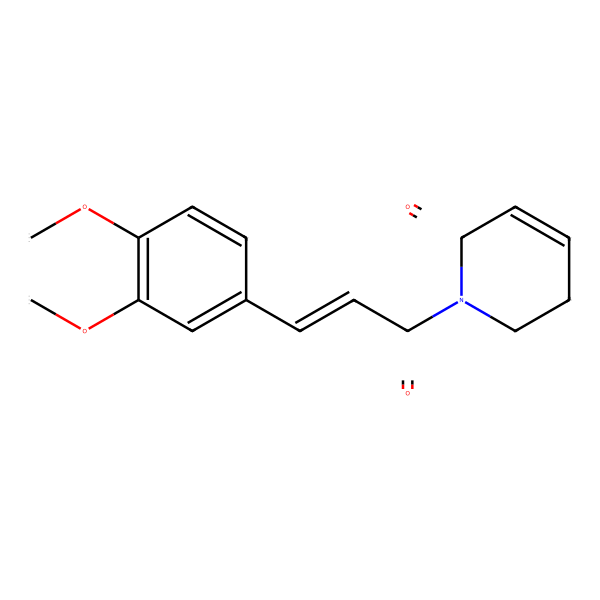

--- Molecule index: 5 ---


[10:36:16] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 8 ignored
[10:36:16] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 10 ignored


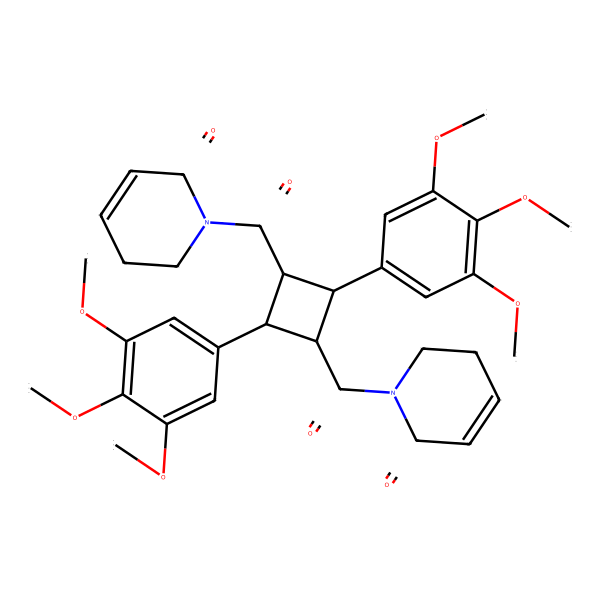

--- Molecule index: 6 ---


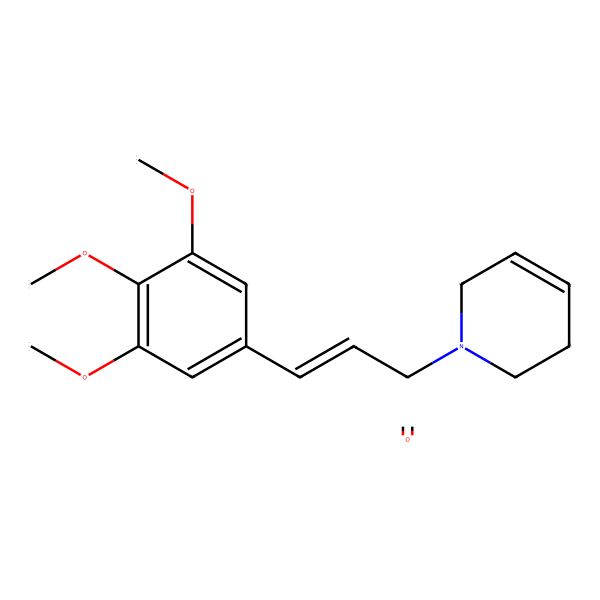

--- Molecule index: 7 ---


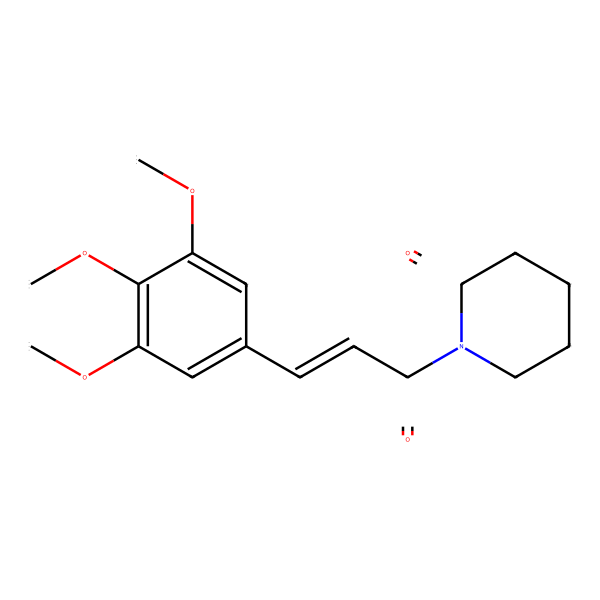

--- Molecule index: 8 ---


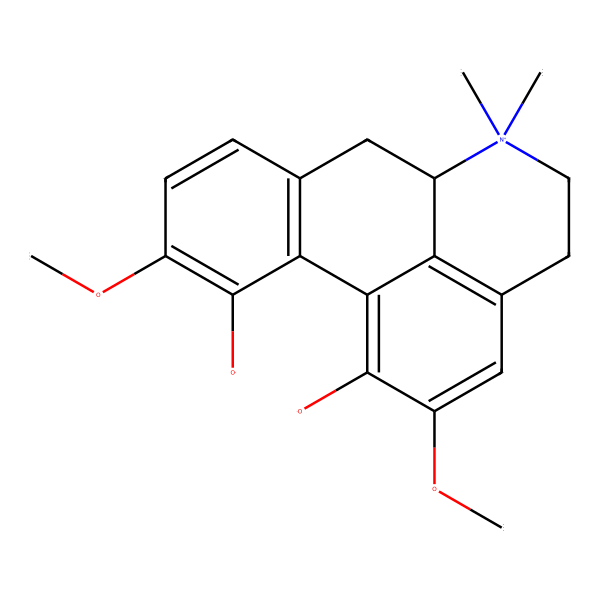

--- Molecule index: 9 ---


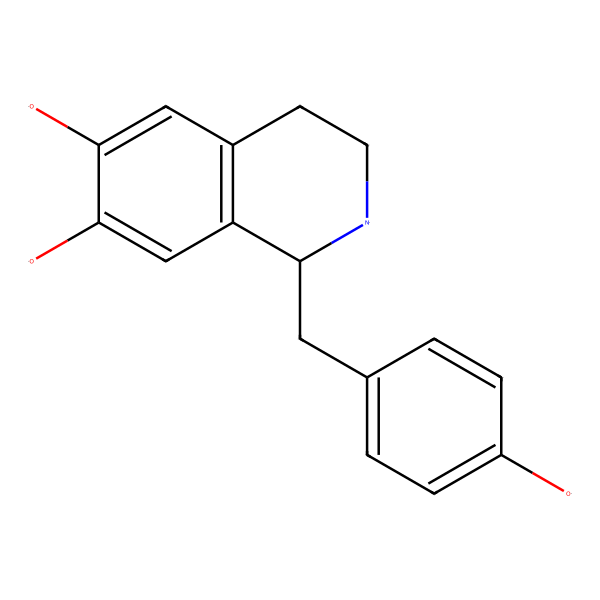

--- Molecule index: 10 ---


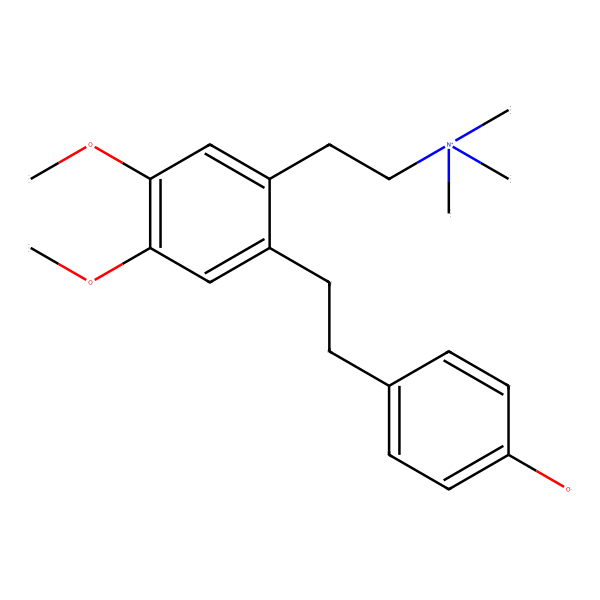

--- Molecule index: 11 ---


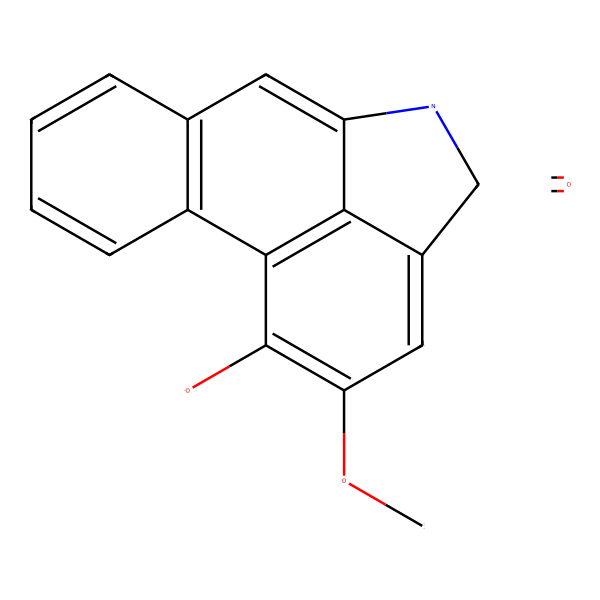

--- Molecule index: 12 ---


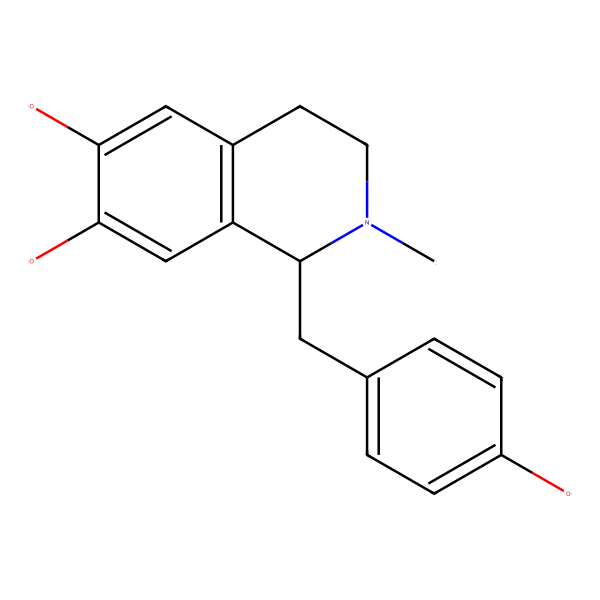

--- Molecule index: 13 ---


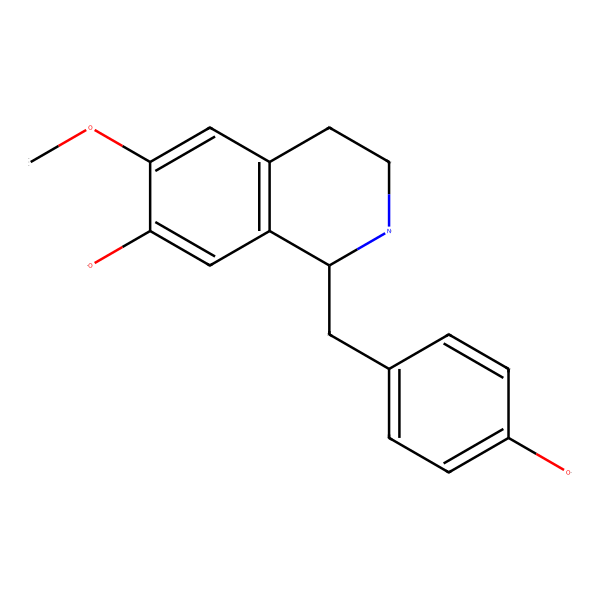

--- Molecule index: 14 ---


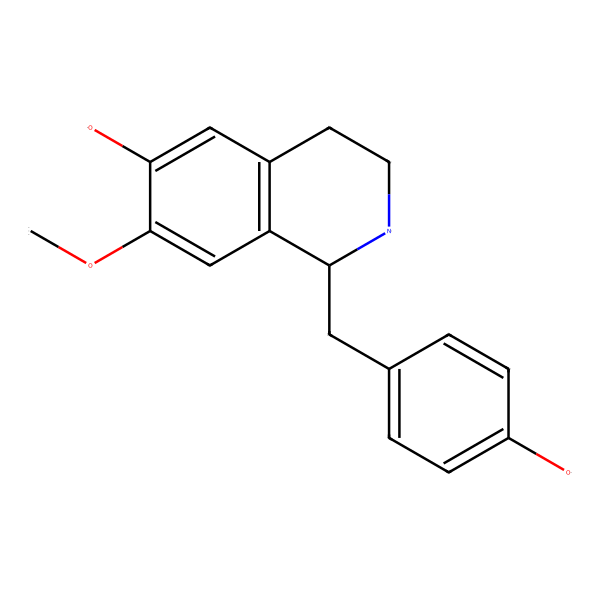

--- Molecule index: 15 ---


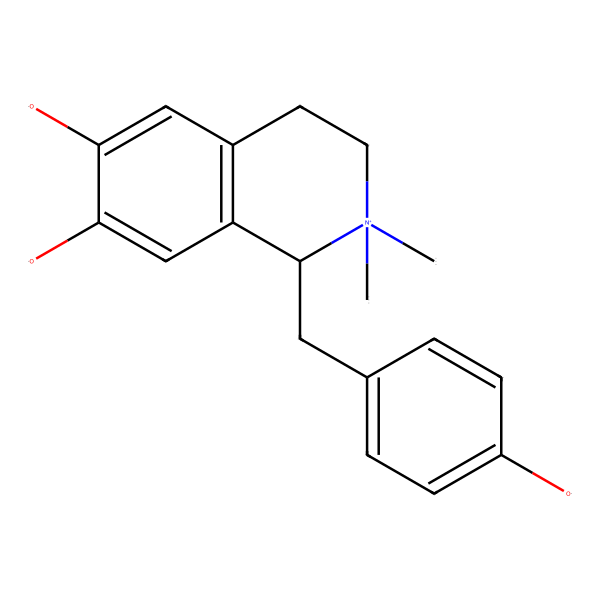

--- Molecule index: 16 ---


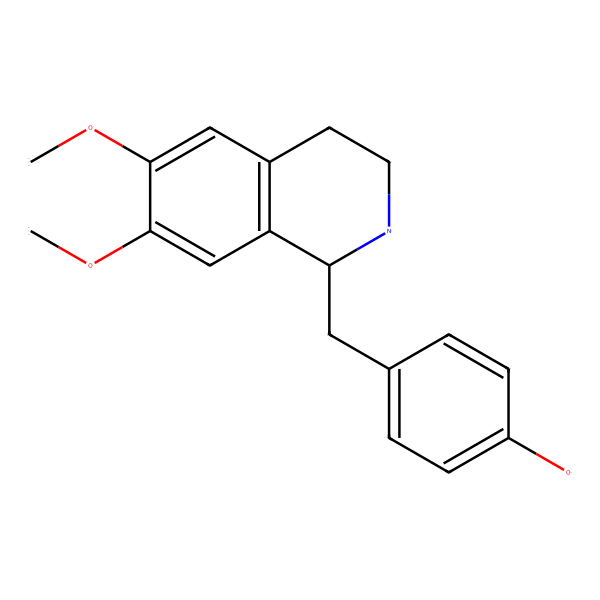

--- Molecule index: 17 ---


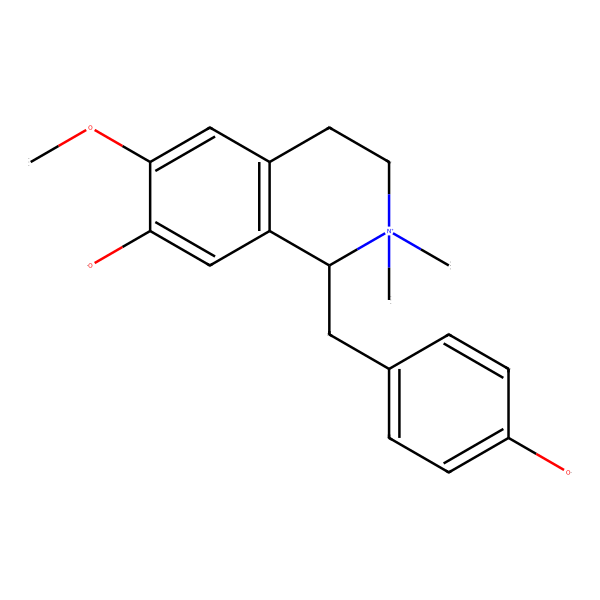

--- Molecule index: 18 ---


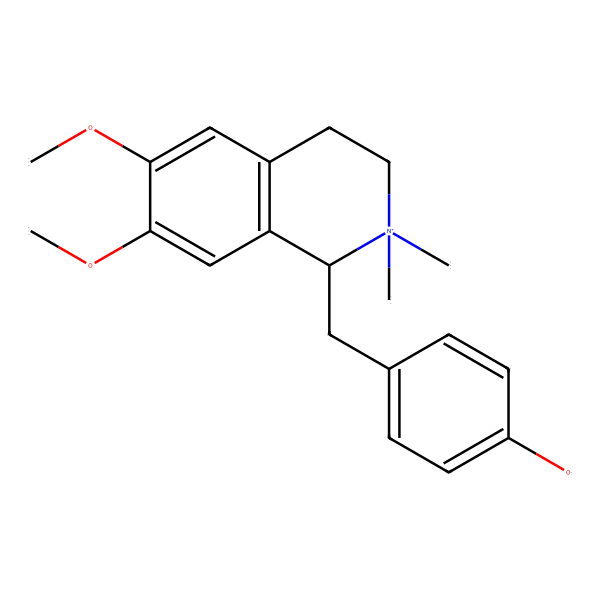

--- Molecule index: 19 ---


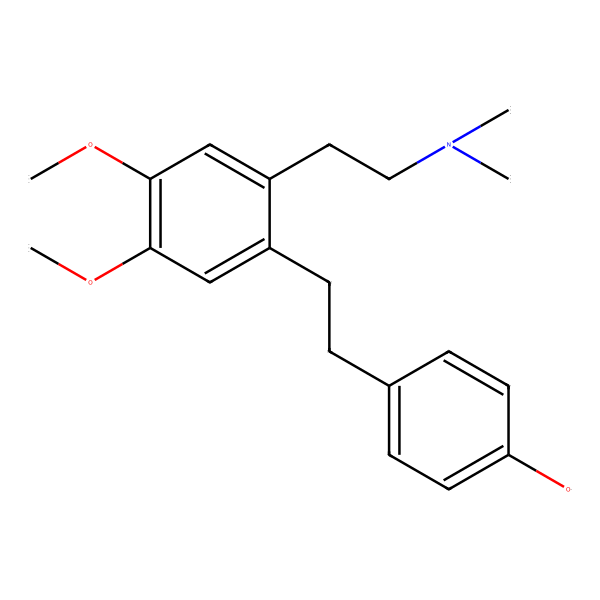

--- Molecule index: 20 ---


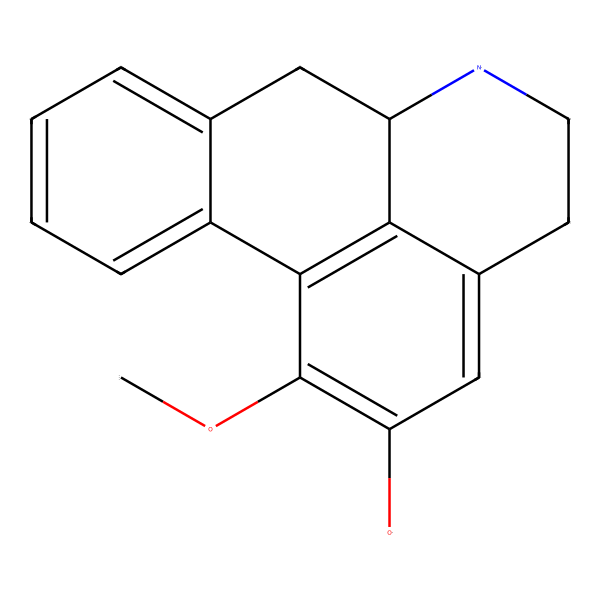

--- Molecule index: 21 ---


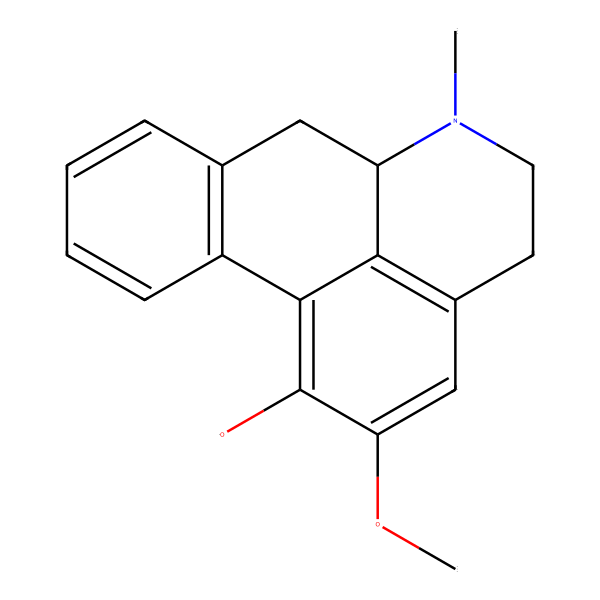

--- Molecule index: 22 ---


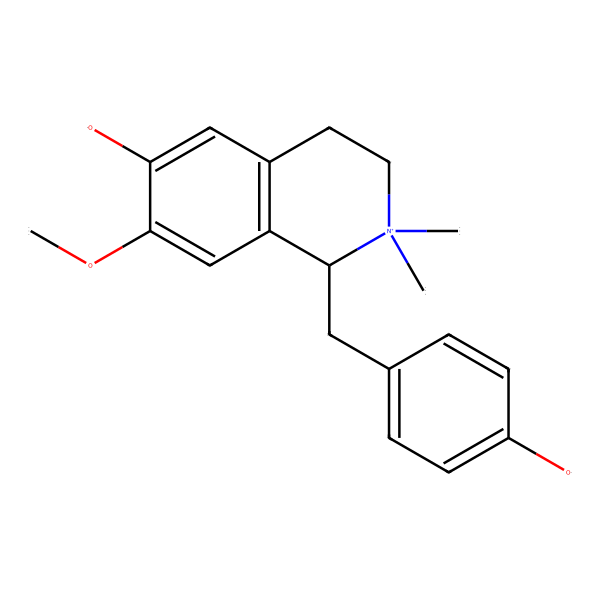

--- Molecule index: 23 ---


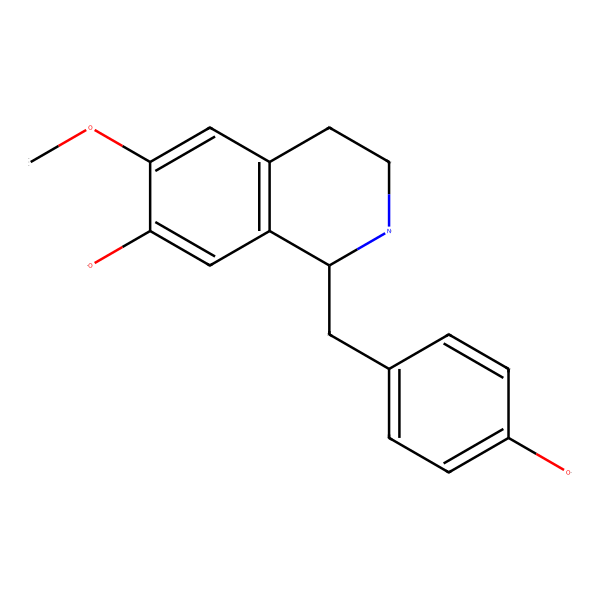

--- Molecule index: 24 ---


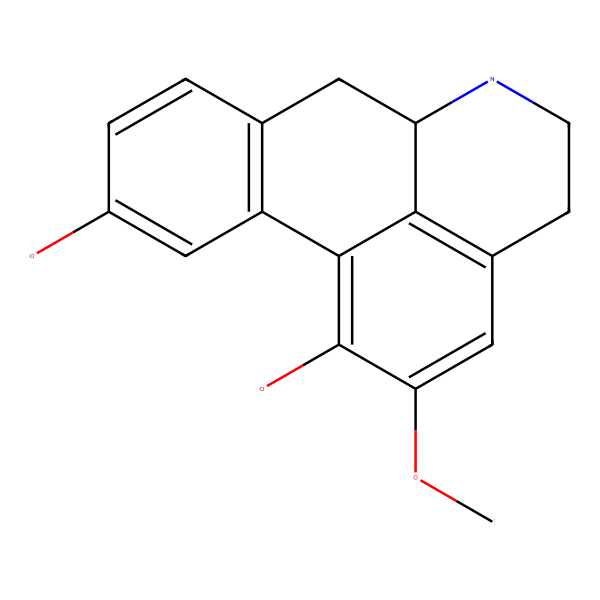

--- Molecule index: 25 ---


[10:36:16] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored


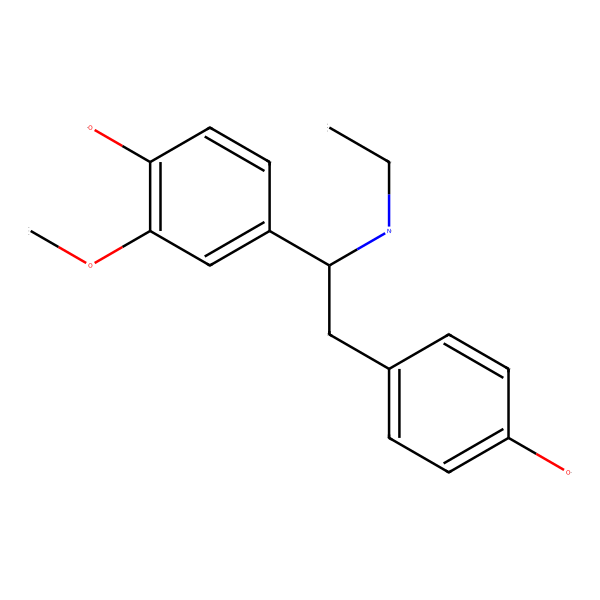

--- Molecule index: 26 ---


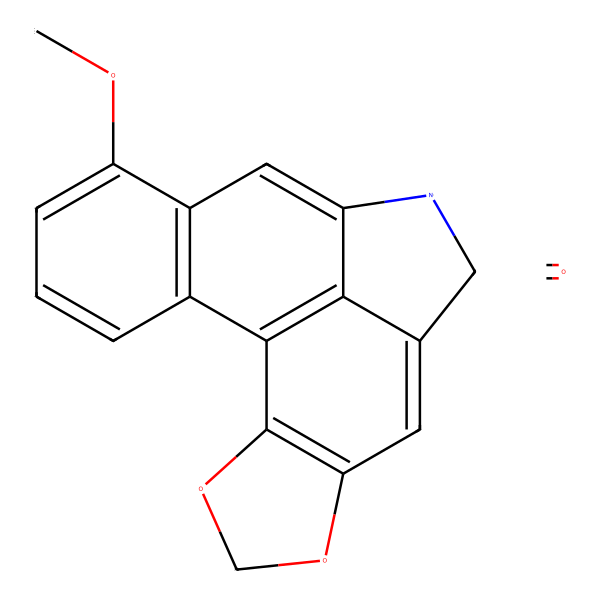

--- Molecule index: 27 ---


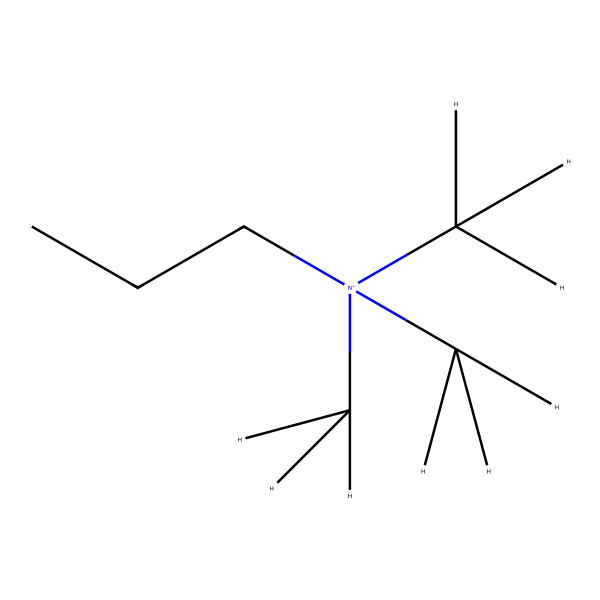

--- Molecule index: 28 ---


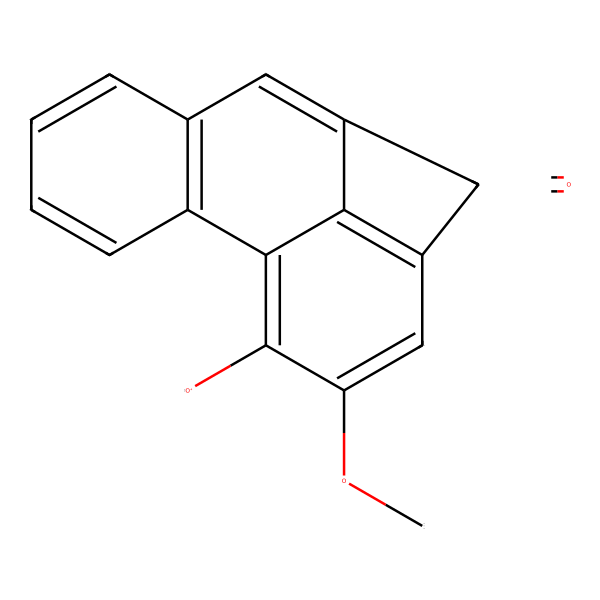

--- Molecule index: 29 ---


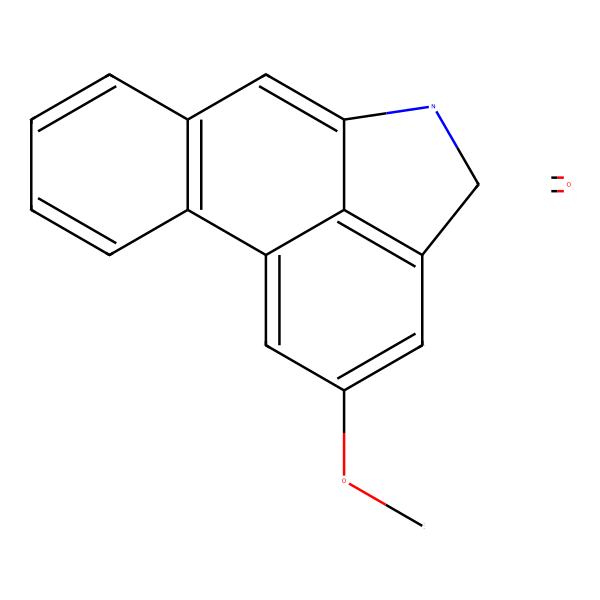

--- Molecule index: 30 ---


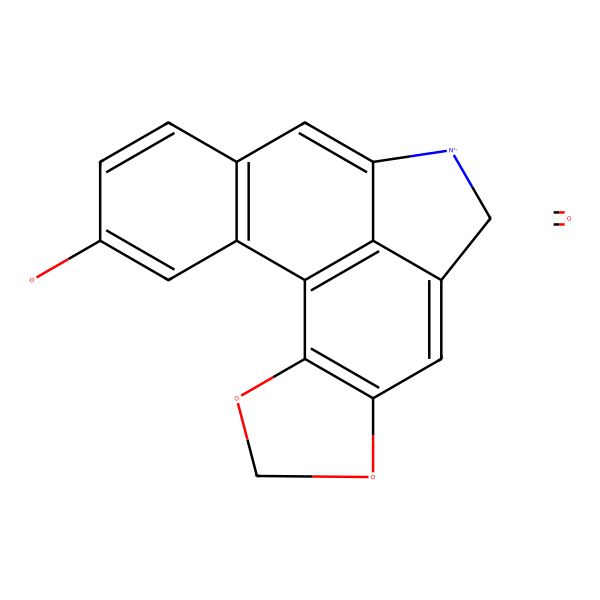

--- Molecule index: 31 ---


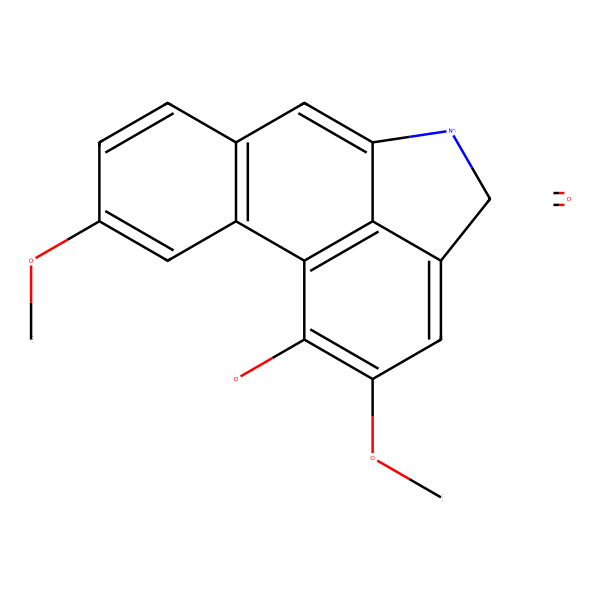

--- Molecule index: 32 ---


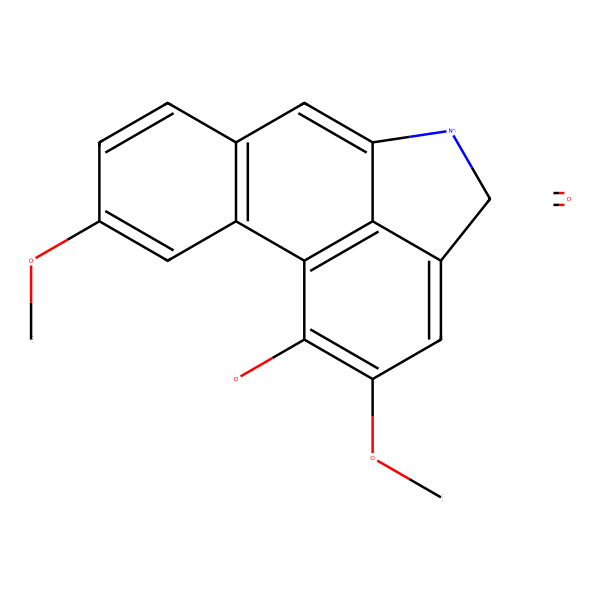

In [38]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.rdMolDraw2D import MolDrawOptions
from IPython.display import display

# load your supplier
sdf_path = "/Users/macbook/CODE/DreaMS_MIMB/data/molecules/structures_v2.sdf"
supplier = Chem.SDMolSupplier(sdf_path, removeHs=False)

# prepare your drawing options
opts = MolDrawOptions()
opts.fontSize = 24           # atom‐label font size (points)
opts.atomLabelFontSize = 24  # explicit override
opts.bondLineWidth = 2.5     # slightly thicker bonds so they don't look spindly

for idx, mol in enumerate(supplier):
    if mol is None:
        continue
    print(f"--- Molecule index: {idx} ---")
    # pass the opts into MolToImage
    img = Draw.MolToImage(mol, size=(600, 600), options=opts)
    display(img)

### CSV Cleaning

In [39]:
import pandas as pd

# 1. Load the CSV
csv_path = "/Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids.csv"
df = pd.read_csv(csv_path)

# 2. Extract the number inside parentheses into a new column 'novel_id'
#    This grabs digits between '(' and ')'
df['novel_id'] = df['Name'].str.extract(r'\((\d+)\)')

# 3. Remove the space + '(number)' from the Name, leaving only the pure name
df['Name'] = df['Name'].str.replace(r'\s*\(\d+\)', '', regex=True)

# 4. (Optional) convert novel_id to integer
df['novel_id'] = df['novel_id'].astype(int)

# 5. Inspect the result
print(df.head())

# 6. Save back to CSV (overwrites original or to a new file)
df.to_csv("/Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids_cleaned.csv",
          index=False)

                                          Name  Adduct       m/z  RT (min)  \
0                               Piperlongumine  [M+H]+  318.1342      8.83   
1                        Dihydropiperlongumine  [M+H]+  320.1497      9.07   
2      1-(3,4,5-Trimethoxycinnamoyl)piperidine  [M+H]+  306.1705      8.90   
3  1-(3,4,5-Trimethoxycinnamoyl)-3-piperideine  [M+H]+  304.1548      9.56   
4                   3'-Demethoxypiperlongumine  [M+H]+  288.1235      8.50   

   MZmine ID Annotation  novel_id  
0        452   Standard         1  
1        463   Standard         2  
2        458   Standard         3  
3        503      MS/MS         4  
4        406   Standard         5  


In [40]:
import pandas as pd

# 1. Load your cleaned CSV with novel_id already parsed
csv_in  = "/Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids_cleaned.csv"
csv_out = "/Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids_mapped.csv"
df = pd.read_csv(csv_in)

# 2. Define your SDF->paper mapping, then invert to paper->sdf
sdf_to_paper = {
    0:  8,
    1:  1,
    2:  3,
    3:  6,
    4:  5,
    5:  7,
    6:  4,
    7:  2,
    8: 20,
    9:  9,
   10: 23,
   11: None,
   12: 12,
   13: None,
   14: 11,
   15: 13,
   16: None,
   17: None,
   18: None,
   19: 22,
   20: 18,
   21: None,
   22: None,
   23: None,
   24: None,
   25: None,
   26: None,
   27: None,
   28: None,
   29: None,
   30: None,
   31: None,
   32: None
}
# invert, dropping SDF indices where paper is None
paper_to_sdf = {paper: sdf for sdf, paper in sdf_to_paper.items() if paper is not None}

# 3. Map novel_id -> sdf index
df['sdf_index'] = df['novel_id'].map(paper_to_sdf)

# 4. Inspect rows that didn’t map
missing = df[df['sdf_index'].isna()]
print("These novel_ids weren’t found in your mapping dict:")
print(missing[['Name','novel_id']])

# 5. Save the augmented CSV
df.to_csv(csv_out, index=False)
print(f"Saved augmented table with sdf_index to:\n  {csv_out}")

These novel_ids weren’t found in your mapping dict:
                  Name  novel_id
9           Coclaurine        10
13       Norarmepavine        14
14            Lotusine        15
15       Magnocurarine        16
16  N-methylarmepavine        17
18          Lirinidine        19
20      Piperolactam A        21
Saved augmented table with sdf_index to:
  /Users/macbook/CODE/DreaMS_MIMB/data/molecules/P__fimbriulatum_Alkaloids_mapped.csv
